# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Model Choice

As a baseline we chose the model that performed best in the [COLET: A dataset for COgnitive workLoad estimation based on eye-tracking](https://www.sciencedirect.com/science/article/pii/S0169260722003716) paper. It was a Gaussian Naive Bayes (GNB) classifier. GNBs are traditional machine learning models. This offers a good starting point to compare them to the newer and more complex deep neural network architectures. 

Approach: As for further data preprocessing - we will first select relevant features, remove empty values and then categorize the mean coginitive load into low/mid/high and low/high recpectively. The mean cognitive load will be used as the target variable to predict.


## Feature Selection

In [2]:
# Load the dataset
import os 

data_folder = '../data/'
dataset_path = os.path.join(data_folder, 'preprocessed_df_v2.csv')
df = pd.read_csv(dataset_path)

df.head()

,participant_id,test_id,test_duration,mental,physical,temporal,performance,effort,frustration,mean,...,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,1,1,33.643950,10,5,15,25,25,10,15.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,F,28,18
1,1,2,28.484322,50,30,25,50,15,25,32.5,...,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,F,28,18
2,1,3,71.423823,100,10,75,80,90,20,62.5,...,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,F,28,18
3,1,4,38.163442,60,15,45,50,20,25,35.8,...,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,F,28,18
4,2,1,41.748047,20,10,20,10,20,15,15.8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,F,28,18


## Relevant Features

We'll use the mean cognitive load as the output we want to predict. Therefore we can drop the following features: 'mental', 'physical', 'temporal', 'performance', 'effort', 'frustration'. Furthermore we can remove the 'participant_id'/'ID' as well as the 'test_id' as they are not relevant for the prediction.

Label:
- mean (categorized as low/mid/high and low/high)

Features:
- gender
- age
- education
- visual_acuity_logmar
- test_duration
- blinkrate (per second)
- fixationrate (per second)
- mean_pupil_diameter
- median_pupil_diameter
- blinkrate_rel (relative change to baseline)
- blinkrate_rel_pct (relative change to baseline in percent)
- fixationrate_rel
- fixationrate_rel_pct
- mean_pupil_diameter_rel
- mean_pupil_diameter_rel_pct
- median_pupil_diameter_rel
- median_pupil_diameter_rel_pct

In [3]:
# Drop not needed features
columns_to_drop = ['mental', 'physical', 'temporal', 'performance', 'effort', 
                   'frustration', 'participant_id', 'test_id']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,test_duration,mean,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,33.643950,15.0,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,F,28,18
1,28.484322,32.5,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,F,28,18
2,71.423823,62.5,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,F,28,18
3,38.163442,35.8,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,F,28,18
4,41.748047,15.8,31.492393,31.393101,0.000000,0.143727,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,F,28,18


In [4]:
# Check dataset for NaN values
df.isna().sum()

test_duration                     0
mean                              0
mean_pupil_diameter               0
median_pupil_diameter             0
blinkrate                         0
fixationrate                      0
blinkrate_rel                     0
blinkrate_rel_pct                52
fixationrate_rel                  0
fixationrate_rel_pct              0
mean_pupil_diameter_rel           0
mean_pupil_diameter_rel_pct       0
median_pupil_diameter_rel         0
median_pupil_diameter_rel_pct     0
visual_acuity_logmar              0
gender                            0
age                               0
education                         0
dtype: int64

In [5]:
# Remove NaN values that happen only in blinkrate_rel_pct, which is the relative change of the blinkate (in percentage) to the baseline.
# If the baseline is 0, the relative change is NaN. In this case we replace NaN with 0 as there's no change.
df['blinkrate_rel_pct'] = df['blinkrate_rel_pct'].fillna(0)

# validate
df.isna().sum()

test_duration                    0
mean                             0
mean_pupil_diameter              0
median_pupil_diameter            0
blinkrate                        0
fixationrate                     0
blinkrate_rel                    0
blinkrate_rel_pct                0
fixationrate_rel                 0
fixationrate_rel_pct             0
mean_pupil_diameter_rel          0
mean_pupil_diameter_rel_pct      0
median_pupil_diameter_rel        0
median_pupil_diameter_rel_pct    0
visual_acuity_logmar             0
gender                           0
age                              0
education                        0
dtype: int64

In [6]:
# Extract labels and create tain, test, validation sets
X = df.drop(['mean'], axis=1)
y = df['mean'] # mean is the mean cognitive workload we want to predict

In [7]:
# transform gender to binary
X['gender'] = X['gender'].map({'F': 0, 'M': 1})
X.head()

,test_duration,mean_pupil_diameter,median_pupil_diameter,blinkrate,fixationrate,blinkrate_rel,blinkrate_rel_pct,fixationrate_rel,fixationrate_rel_pct,mean_pupil_diameter_rel,mean_pupil_diameter_rel_pct,median_pupil_diameter_rel,median_pupil_diameter_rel_pct,visual_acuity_logmar,gender,age,education
0,33.643950,43.855534,43.893976,0.059446,0.295946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0,28,18
1,28.484322,42.935538,43.021599,0.000000,0.175533,-0.059446,-100.000000,-0.120413,-40.687440,-0.919996,-2.097788,-0.872377,-1.987465,-0.04,0,28,18
2,71.423823,44.704459,44.791630,0.196013,0.196018,0.136567,229.732630,-0.099928,-33.765546,0.848925,1.935731,0.897654,2.045050,-0.04,0,28,18
3,38.163442,45.762156,45.845470,0.052406,0.288263,-0.007040,-11.842464,-0.007684,-2.596309,1.906622,4.347507,1.951494,4.445927,-0.04,0,28,18
4,41.748047,31.492393,31.393101,0.000000,0.143727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.10,0,28,18


In [8]:
# Categorize labels
y_binary = df['mean'].apply(lambda x: 'low' if x <= 50 else 'high')
y_multiclass = df['mean'].apply(lambda x: 'low' if x <= 33 else ('mid' if x <= 66 else 'high'))

# Examples of labels
y_binary.head(10), y_multiclass.head(10)

(0     low
 1     low
 2    high
 3     low
 4     low
 5     low
 6     low
 7    high
 8     low
 9     low
 Name: mean, dtype: object,
 0     low
 1     low
 2     mid
 3     mid
 4     low
 5     mid
 6     low
 7    high
 8     low
 9     low
 Name: mean, dtype: object)

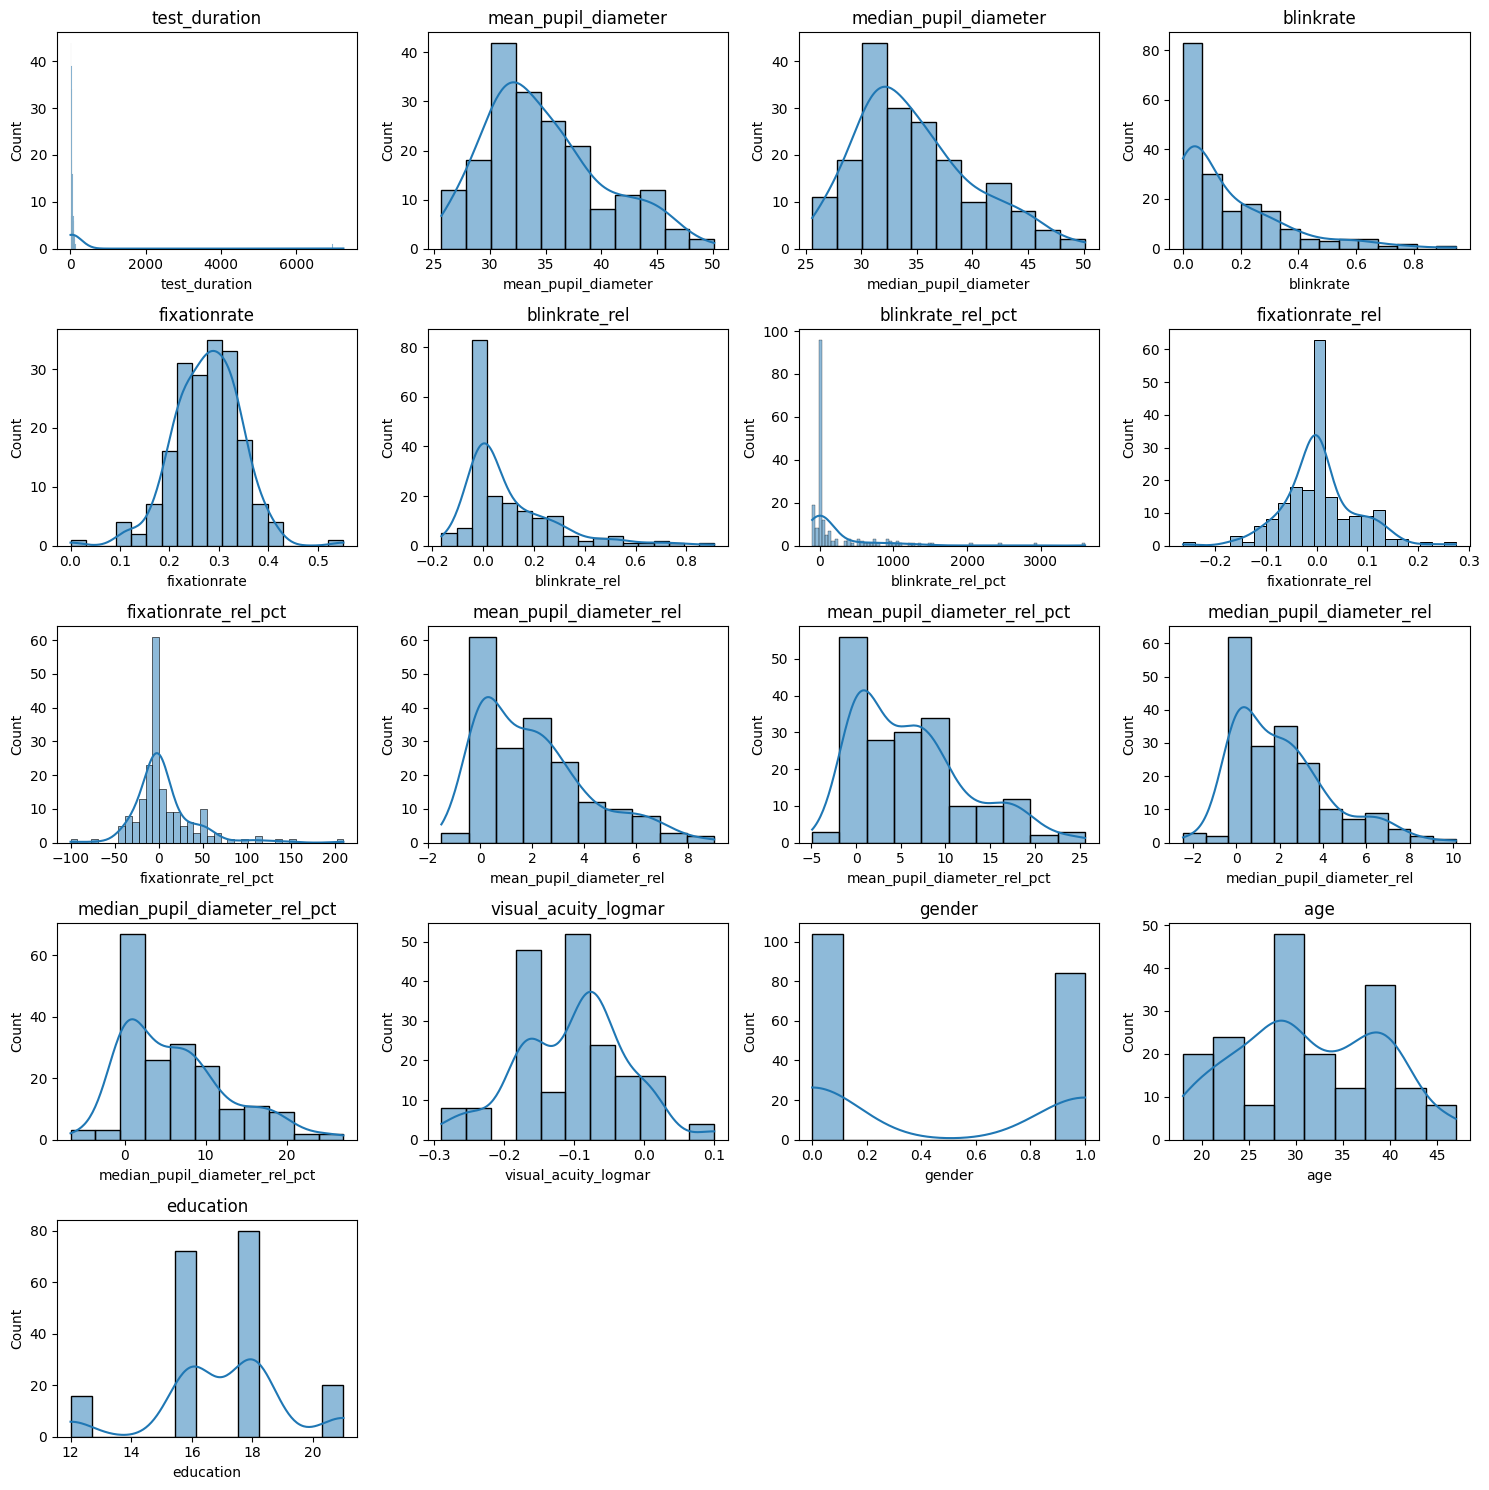

In [9]:
# Check distributions of features, so see if they have varying scales. If a lot / all features follow normal distr. we can use StandardScaler
# otherwise we will use MinMaxScaler to that all features have a similar scale.

def plot_feature_distributions(dataframe):
    num_features = dataframe.shape[1]
    num_cols = 4
    num_rows = (num_features + num_cols - 1) // num_cols
    
    plt.figure(figsize=(15, num_rows * 3))
    for i, column in enumerate(dataframe.columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(dataframe[column], kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.show()


plot_feature_distributions(X)

Given that many of our features do not follow a normal distribution and have varying scales, MinMaxScaler will be chosen, so all features have the same scale. 

In [10]:
# Scale features
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [11]:
# Encode labels, sci-kit learn can internally handle strings, but we convert them anyways for good practice
label_encoder_bin = LabelEncoder()
label_encoder_mult = LabelEncoder()

y_binary_encoded = label_encoder_bin.fit_transform(y_binary)
y_multiclass_encoded = label_encoder_mult.fit_transform(y_multiclass)

# Few examples of the encoded labels of binary labels
print(f"Binary Labels:")
for original, encoded in zip(y_binary[:10], y_binary_encoded[:10]):
    print(f"Original Label: '{original}', Encoded Label: {encoded}")

print('--------------------')

print(f"Multiclass Labels:")
for original, encoded in zip(y_multiclass[:10], y_multiclass_encoded[:10]):
    print(f"Original Label: '{original}', Encoded Label: {encoded}")

Binary Labels:
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
--------------------
Multiclass Labels:
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1
Original Label: 'mid', Encoded Label: 2
Original Label: 'mid', Encoded Label: 2
Original Label: 'low', Encoded Label: 1
Original Label: 'mid', Encoded Label: 2
Original Label: 'low', Encoded Label: 1
Original Label: 'high', Encoded Label: 0
Original Label: 'low', Encoded Label: 1
Original Label: 'low', Encoded Label: 1


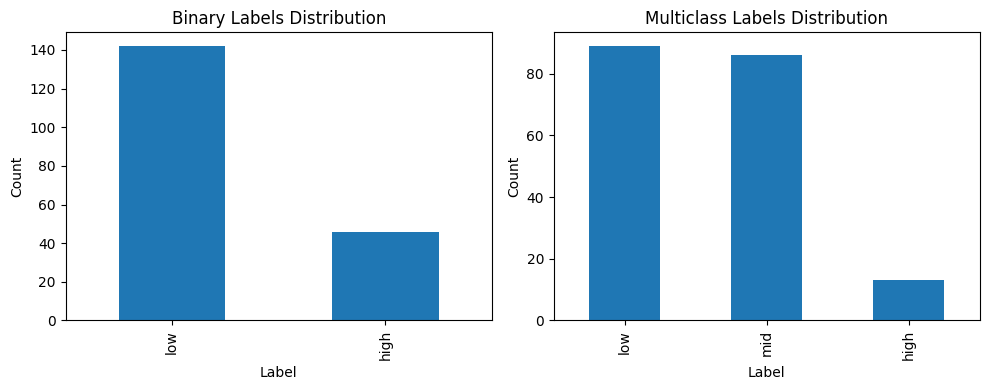

In [12]:
# Quick check how the labels are distributed
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Binary label distribution
y_binary.value_counts().plot.bar(ax=axes[0], title='Binary Labels Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# Multiclass label distribution
y_multiclass.value_counts().plot.bar(ax=axes[1], title='Multiclass Labels Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [13]:
# Splitting the dataset
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary_encoded, test_size=0.20, random_state=42)
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(X, y_multiclass_encoded, test_size=0.20, random_state=42)

train_samples_bin = X_train_bin.shape[0]
test_samples_bin = X_test_bin.shape[0]

print(f"Binary Training Set Samples: {X_train_bin.shape[0]}")
print(f"BInary Testing Set Samples: {X_test_bin.shape[0]}")

print('-'*25)

print(f"Multiclass Training Set Samples: {X_train_mult.shape[0]}")
print(f"Multiclass Testing Set Samples: {X_test_mult.shape[0]}")

Binary Training Set Samples: 150
BInary Testing Set Samples: 38
-------------------------
Multiclass Training Set Samples: 150
Multiclass Testing Set Samples: 38


## Baseline Model - Gaussian Naive Bayes Classifier (GNB)

In [14]:
# Training the GNB classifier for binary classification
gnb_bin = GaussianNB()
gnb_bin.fit(X_train_bin, y_train_bin)

# Training the GNB classifier for multi-class classification 
gnb_mult = GaussianNB()
gnb_mult.fit(X_train_mult, y_train_mult)

GaussianNB()

## Evaluation

In [15]:
# Evaluate the baseline models

# Binary classification
y_val_pred_bin = gnb_bin.predict(X_test_bin)

accuracy_val_bin = accuracy_score(y_test_bin, y_val_pred_bin)
precision_val_bin = precision_score(y_test_bin, y_val_pred_bin, average='weighted')
recall_val_bin = recall_score(y_test_bin, y_val_pred_bin, average='weighted')
f1_val_bin = f1_score(y_test_bin, y_val_pred_bin, average='weighted')
conf_matrix_val_bin = confusion_matrix(y_test_bin, y_val_pred_bin)

print('Results for binary classification:')
print('Accuracy:', accuracy_val_bin)
print('Precision:', precision_val_bin)
print('Recall:', recall_val_bin)
print('F1 Score:', f1_val_bin)

print('-'*25)

# multiclass classification
y_val_pred_mult = gnb_mult.predict(X_test_mult)

accuracy_val_mult = accuracy_score(y_test_mult, y_val_pred_mult)
precision_val_mult = precision_score(y_test_mult, y_val_pred_mult, average='weighted')
recall_val_mult = recall_score(y_test_mult, y_val_pred_mult, average='weighted')
f1_val_mult = f1_score(y_test_mult, y_val_pred_mult, average='weighted')
conf_matrix_val_mult = confusion_matrix(y_test_mult, y_val_pred_mult)

print('Results for multiclass classification:')
print('Accuracy:', accuracy_val_mult)
print('Precision:', precision_val_mult)
print('Recall:', recall_val_mult)
print('F1 Score:', f1_val_mult)

Results for binary classification:
Accuracy: 0.6842105263157895
Precision: 0.6739323055112528
Recall: 0.6842105263157895
F1 Score: 0.6771255060728746
-------------------------
Results for multiclass classification:
Accuracy: 0.631578947368421
Precision: 0.775
Recall: 0.631578947368421
F1 Score: 0.6538011695906433


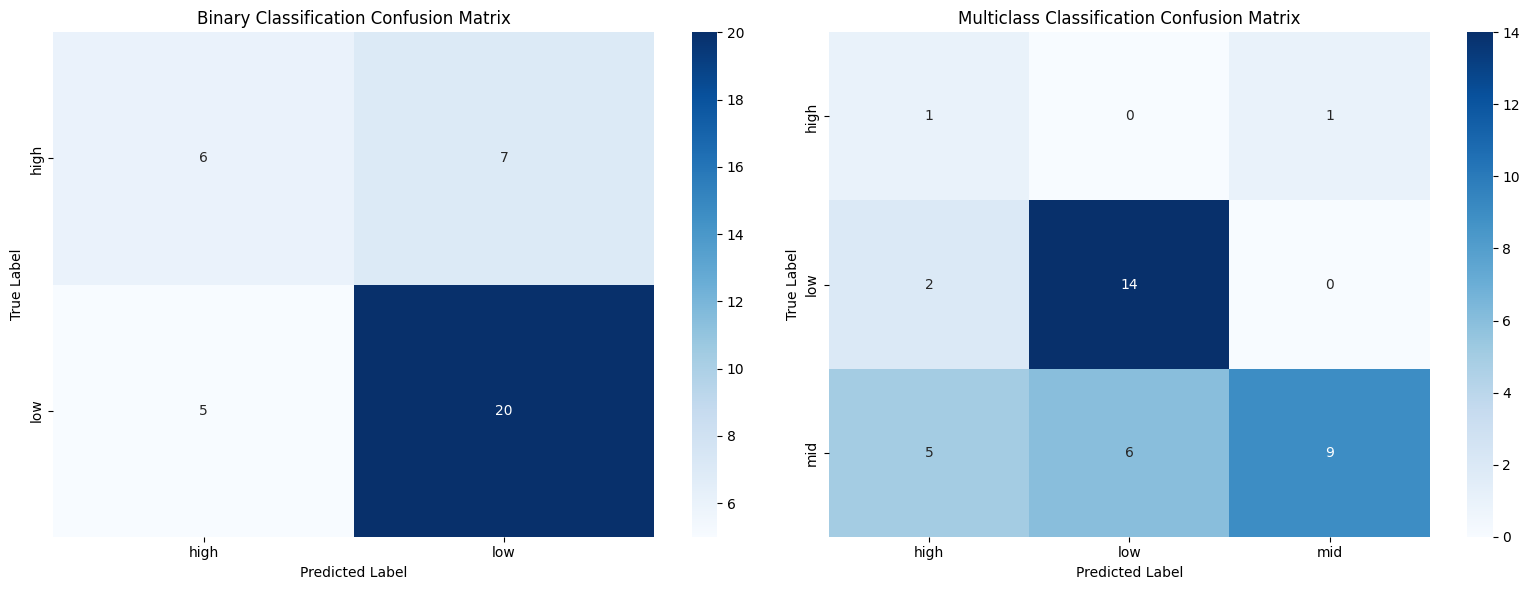

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the binary confusion matrix
sns.heatmap(conf_matrix_val_bin, annot=True, fmt="d", cmap='Blues', 
            xticklabels=label_encoder_bin.classes_, yticklabels=label_encoder_bin.classes_, ax=axes[0])
axes[0].set_title('Binary Classification Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Plot the multiclass confusion matrix
sns.heatmap(conf_matrix_val_mult, annot=True, fmt="d", cmap='Blues', 
            xticklabels=label_encoder_mult.classes_, yticklabels=label_encoder_mult.classes_, ax=axes[1])
axes[1].set_title('Multiclass Classification Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# Adjust layout
plt.tight_layout()
plt.show()

### Key takeaways for binary case:
- Performance is moderate, but not great, quite balanced percision and recall
- Model makes considerable amount of errors, especially predicting the 'high' cases. It misclassified 'high' 7 times as 'low'
- Relatively good in predicting 'low' cases
- Indicative of the unbalanced distribution of the data

### Key takeaways for multiclass case:
- There's a noticeable issue with 'mid' being misclassified as both 'high' and 'low' in the multiclass case
- The best performance is in predicting 'low', which it does correctly most of the time, but there is still room for improvement in distinguishing 'low' from 'mid'
- Very few true positives for 'high' class, which suggest that the class is quite underrepresented in the dataset
- Relatively high precision, meaning it has quite high confidence in the predictions
- Recall is lower, indicating that it misses a good amount of true cases (especially in 'mid' class)

### Going forward:
- The dataset is severly unbalanced, 'high' class is underrepresented for both cases (binary and multiclass)
- We need to address this imbalance, probably by oversampling, since we cannot undersample due to already low amount of data
- Synthetic data can be generated with techniques like [SMOTE](https://arxiv.org/abs/1106.1813) or training a [GAN](https://arxiv.org/abs/1406.2661)/[cGAN](https://arxiv.org/abs/1411.1784)